In [2]:
# define the paths to data folders
path_to_images = "/home/aditis/decodingEEG/DecodeEEG/data/images/"
path_to_eeg = "/home/aditis/decodingEEG/DecodeEEG/data/PreprocessedEEG/"
path_to_features = "/home/aditis/decodingEEG/DecodeEEG/data/feature_vectors/"

In [ ]:
# define the image to vector class used for extraction

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    def __init__(self, cuda=False, model='resnet-18', layer='default', layer_output_size=512, gpu=0):
            """ Img2Vec
            :param cuda: If set to True, will run forward pass on GPU
            :param model: String name of requested model
            :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
            :param layer_output_size: Int depicting the output size of the requested layer
            """
            self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
            self.layer_output_size = layer_output_size
            self.model_name = model

            self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

            self.model = self.model.to(self.device)

            self.model.eval()

            self.scaler = transforms.Resize((224, 224))
            self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
            self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

        my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

        def copy_data(m, i, o):
            my_embedding.copy_(o.data)

        h = self.extraction_layer.register_forward_hook(copy_data)
        with torch.no_grad():
            h_x = self.model(image)
        h.remove()

        return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(weights=models.ResNet18_Weights.DEFAULT)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer
        else:
            raise KeyError('Model %s was not found' % model_name)

In [22]:
# test the feature vector for a sample image
from PIL import Image
img2vec = Img2Vec()
img = Image.open(path_to_images+"training_images/00001_aardvark/aardvark_10s.jpg").convert('RGB')
vec = img2vec.get_vec(img)

Size of feature vector:  (512,)
Sample image:


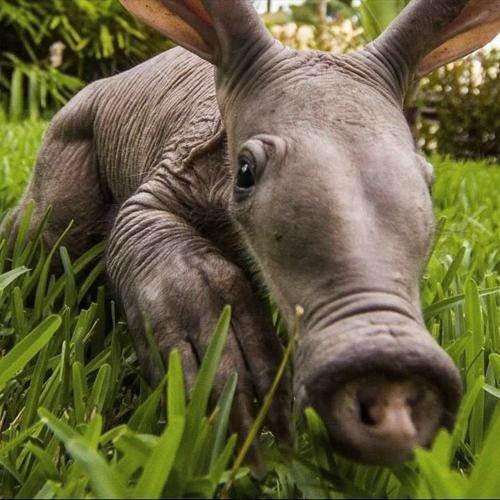

In [26]:
print("Size of feature vector: " ,vec.shape)
print("Sample image:")
img


Max value in the vector:  4.857879
Min value in the vector:  0.0


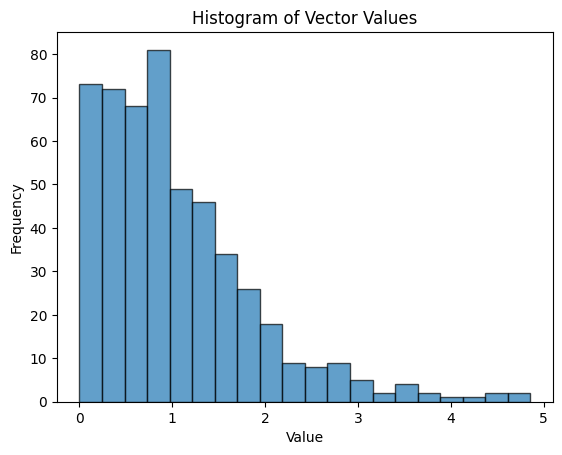

In [33]:
import matplotlib.pyplot as plt
print("Max value in the vector: ", vec.max())
print("Min value in the vector: ", vec.min())

# Calculate histogram data
bins = 20  # Number of bins
hist, bin_edges = np.histogram(vec, bins=bins)

#print("Histogram frequencies:", hist)
#print("Bin edges:", bin_edges)

# Plot the histogram
plt.hist(vec, bins=bins, edgecolor='black', alpha=0.7)
plt.title("Histogram of Vector Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

Training EEG single image data shape:
(4, 17, 100)
(Training EEG repetitions × EEG channels × EEG time points)



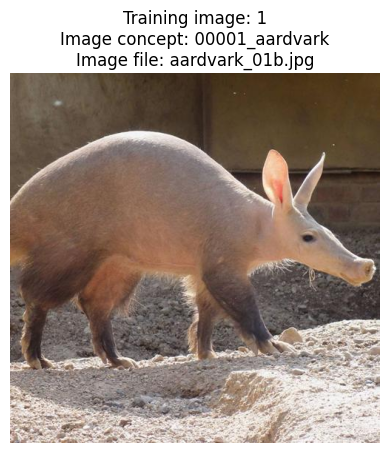

In [61]:
import os

train_img_idx =  0 #@param {type:"integer"}
eeg_data_train = np.load(path_to_eeg+"sub-01/preprocessed_eeg_training.npy", allow_pickle=True).item()
img_metadata = np.load(os.path.join(path_to_images, 'image_metadata.npy'),
	allow_pickle=True).item()
eeg_data_single_image = eeg_data_train['preprocessed_eeg_data'][train_img_idx]
print('Training EEG single image data shape:')
print(eeg_data_single_image.shape)
print('(Training EEG repetitions × EEG channels × EEG time points)\n')

train_img_dir = os.path.join(path_to_images, 'training_images',
	img_metadata['train_img_concepts'][train_img_idx],
	img_metadata['train_img_files'][train_img_idx])
train_img = Image.open(train_img_dir).convert('RGB')

plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(train_img_idx+1) + '\nImage concept: ' +\
	img_metadata['train_img_concepts'][train_img_idx] + '\nImage file: ' +\
	img_metadata['train_img_files'][train_img_idx]);

### Spectrogram Analysis

In [49]:
data = np.load(path_to_eeg+"sub-01/preprocessed_eeg_training.npy", allow_pickle=True).item()
data = data['preprocessed_eeg_data']
data.shape

img_sig = data[0,0,:,:]
img_sig.shape

(17, 100)

(17, 401, 75)


/tmp/ipykernel_1621901/1710982206.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_1621901/1710982206.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


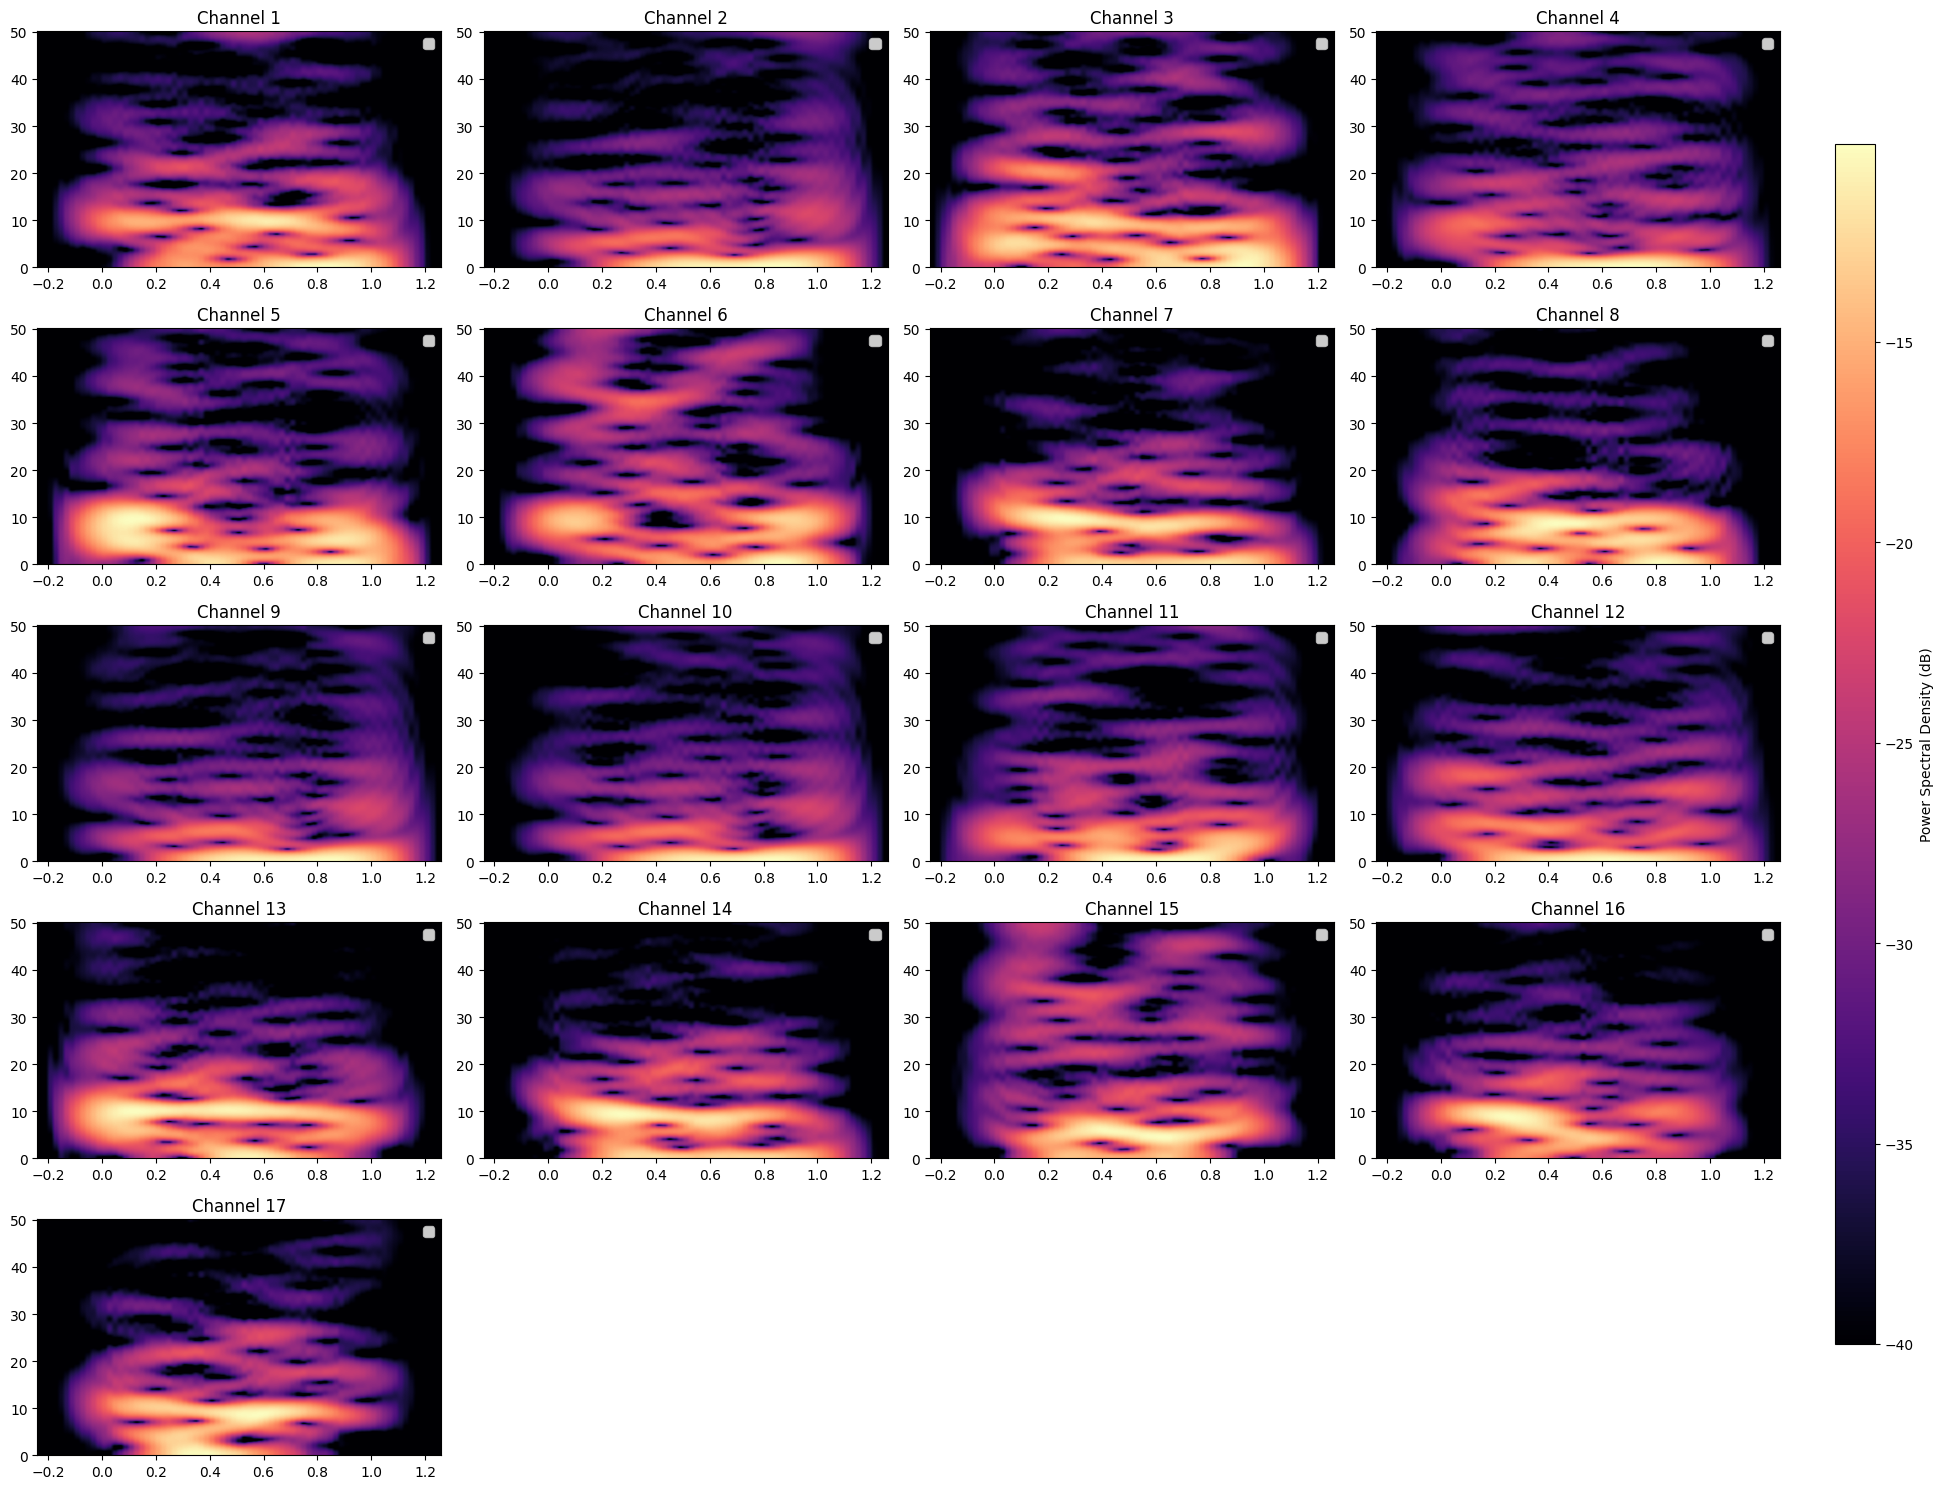

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import square, ShortTimeFFT
from scipy.signal.windows import gaussian

# Spectrogram Parameters
g_std = 12  # standard deviation for Gaussian window in samples
win = gaussian(50, std=g_std, sym=True)  # symmetric Gaussian wind.


# sample signal
T_x, N = 1 / 100, 100  # 20 Hz sampling rate for 50 s signal
t_x = np.arange(N) * T_x  # time indexes for signal

SFT = ShortTimeFFT(win, hop=2, fs=1/T_x, mfft=800, scale_to='psd')
#x = square(2*np.pi*np.cumsum(f_i)*T_x)  # the signal
x = img_sig

# Calculate Spectrogram
Sx2 = SFT.spectrogram(x)  # calculate absolute square of STFT

print(Sx2.shape)

# Visualize
# Parameters
rows, cols = 5, 4  # Grid of subplots (5x4) for 17 plots
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))  # Create subplots

# Flatten axes array to make it easier to handle
axes = axes.flatten()

# Time range for extent
t_lo, t_hi = SFT.extent(N)[:2]  # Time range of plot

# Loop over all 17 spectrograms to plot
for idx in range(Sx2.shape[0]):
    ax = axes[idx]
    Sx = Sx2[idx, :, :]
    Sx_dB = 10 * np.log10(np.fmax(Sx, 1e-4))  # Limit range to -40 dB
    
    # Plot spectrogram
    im = ax.imshow(Sx_dB, origin='lower', aspect='auto',
                   extent=SFT.extent(N), cmap='magma')
    
    # Title and labels
    ax.set_title(f"Channel {idx + 1}")
    ax.set_xlim(t_lo, t_hi)
    ax.legend()

# Hide any unused subplots
for ax in axes[Sx2.shape[0]:]:
    ax.axis('off')

# Add colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Position for colorbar
fig.colorbar(im, cax=cbar_ax, label='Power Spectral Density (dB)')

fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
plt.show()


(40, 512)


/home/aditis/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


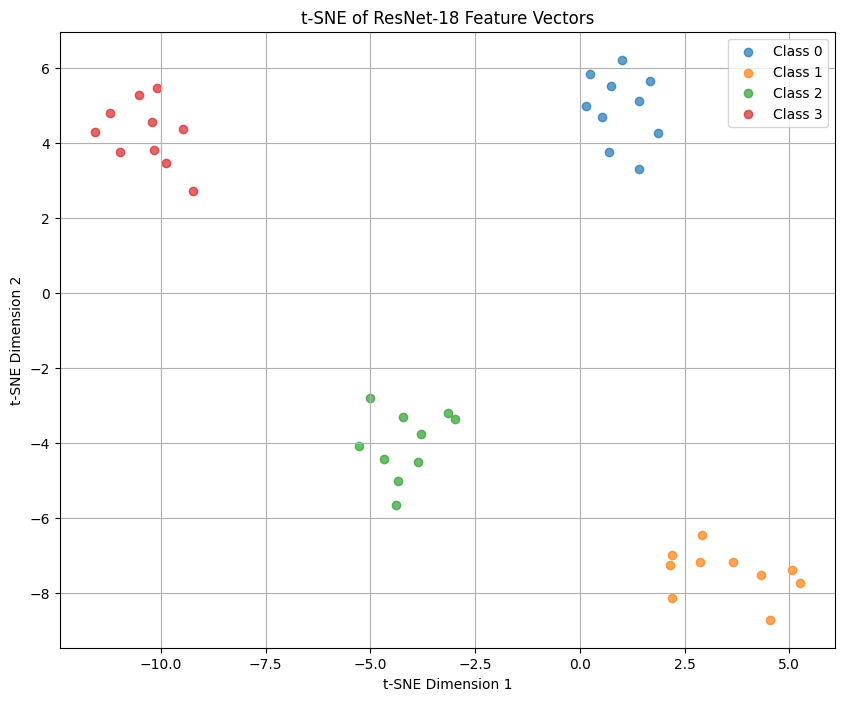

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

# Initialize an empty list to store the loaded arrays
data = []

classes = ["00001_aardvark/", "00002_abacus/" ,"00045_baby/", "00553_football/"]

for clas in classes:
    feature_path  = path_to_features + "training/" + clas
    files = os.listdir(feature_path)
    for file in files:
        if file.endswith('.npy'):  # Ensure it's a .npy file
            file_path = feature_path + file
            array = np.load(file_path)  # Load the .npy file
            data.append(array)         # Append to the list

    
# Convert the list of arrays into a matrix
matrix = np.vstack(data)  # Stack arrays vertically

# Verify the shape
print(matrix.shape)  # Output: (30, 512)

        
# Replace these with your actual feature vectors and labels
#X = np.random.rand(30, 512)  # Replace with ResNet-18 feature vectors (e.g., shape (30, 512))
y = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)  # Class labels for 3 classes

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=1000)
X_embedded = tsne.fit_transform(matrix)  # Shape (30, 2)

# Plot t-SNE
plt.figure(figsize=(10, 8))
for class_label in np.unique(y):
    plt.scatter(X_embedded[y == class_label, 0],
                X_embedded[y == class_label, 1],
                label=f"Class {class_label}", alpha=0.7)

plt.title("t-SNE of ResNet-18 Feature Vectors")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.show()
